# A Gentle (Mathematicians) Introduction to PyTorch and Neural Networks Part 02
#### Todo: Change intro
In this blog posts, I'd like to introduce a commonly used optimizer for training models such as the logistic model we introduced in the [last post](https://linus-lach.de/posts/post-with-code/pytorch/post_01).

The structure of this post is as follows:
First, we familiarize ourselves a bit with the `PyTorch` framework. To build on this newly gained knowledge, we build a logistic model with `PyTorch` and gain some understanding about the binary cross-entropy loss in a theoretical setting.
In the final part we will learn how to train our logistic regression model to achieve a good fit on given data.

## (Stochastic) gradient descent

In [1]:
#Some packages needed throughout the article
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Gradient descent in one dimension


In [2]:
N=200
X = np.linspace(-2,6,N)
def f(x):
    return (x-2)**2

In [3]:
def gd_1d(epochs ,lr ,f ,x):
    coord = []
    for epoch in range(epochs):
        loss = f(x)
        coord.append([x.data,loss.data])
        loss.backward()
        x.data = x.data - lr * x.grad.data
        x.grad.data.zero_()

    return np.transpose(np.reshape(coord,(epochs,2)))


In [4]:
x0 = torch.tensor(-1.0,requires_grad=True)
lr = 0.1
epochs = 20
coord = gd_1d(epochs,lr,f,x0)
show_plt = False
if show_plt is True:
    plt.plot(X,f(X))
    plt.plot(coord[0],coord[1],'-or')
    plt.xlim((-2,6))
    plt.ylim((-2,10))


In [5]:
def f(x):
    return 0.5*(0.75*x-1.2)**4-2*(0.75*x-1)**2+2


In [6]:
x0 = torch.tensor(-1.0,requires_grad=True)
lr = 0.1
epochs = 20
coord = gd_1d(epochs,lr,f,x0)
show_plt = False
if show_plt is True:
    plt.plot(X,f(X))
    plt.plot(coord[0],coord[1],'-or')
    plt.xlim((-2,6))
    plt.ylim((-2,10))


In [7]:
x0 = torch.tensor(-1.0,requires_grad=True)
lr = 0.40
epochs = 20
coord = gd_1d(epochs,lr,f,x0)
show_plt = False
if show_plt is True:
    plt.plot(X,f(X))
    plt.plot(coord[0],coord[1],'-or')
    plt.xlim((-2,6))
    plt.ylim((-2,10))


## (Stochastic) Gradient descent in two dimensions

Motivate Gradient descent in two dimensions using error function from first post.

In [39]:
# Create a dataset class that produces our example data

class Data_2(Dataset):

    def __init__(self, soft_max=False):
        self.x = torch.arange(-2, 2, 0.1).view(-1, 1)
        if soft_max:
            self.y = torch.zeros(self.x.shape[0])
        else:
            self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.5] = 1
        if soft_max:
            self.y = self.y.type(torch.LongTensor)
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

In [40]:
W = torch.arange(0,10,0.1)
B = torch.arange(0,10,0.1)

WW,BB = torch.meshgrid(W,B,indexing = 'ij')

In [41]:
data_2 = Data_2()
x0 = data_2.x[11]
y0 = data_2.y[11]
loss = nn.BCELoss()

def wb_loss(w,b):
    yhat = torch.sigmoid(x0*w+b)
    return loss(yhat,y0)

In [42]:
ZZ = torch.zeros_like(WW)
for i,w in enumerate(W):
    for j,b in enumerate(B):
        ZZ[i,j] = wb_loss(w,b).detach()

In [43]:
def train_model_GD(iter,lr,f,x1,x2):
    COORD = []
    for epoch in range(iter):
        loss = f(x1,x2)
        COORD.append([x1.data,x2.data,loss.data])
        loss.backward()
        x1.data = x1.data - lr * x1.grad.data
        x2.data = x2.data - lr * x2.grad.data

        x1.grad.data.zero_();x2.grad.data.zero_()

    return np.transpose(np.reshape(COORD,(iter,3)))


In [44]:
w0 = torch.tensor([0.5],requires_grad=True)
b0 = torch.tensor([9.0],requires_grad=True)

In [45]:
coord = train_model_GD(20,0.5,wb_loss,w0,b0)

In [54]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

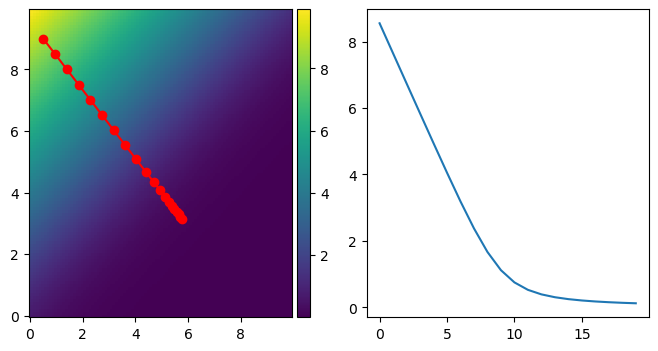

In [57]:
fig = plt.figure(figsize = (8,4))

ax1 = fig.add_subplot(121)
im1 = ax1.pcolor(WW,BB,ZZ)
im2 = ax1.plot(coord[0],coord[1],'-or')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im3 = ax2.plot(coord[2])



In [16]:
def f_(x,y):
    return 2*(2-x)**2*(torch.exp(-1*(x**2)-(y+1)**2))-15*(1/5*x-x**3-y**3)*torch.exp(-x**2 - y**2)-1/3*torch.exp(-(x + 1)**2 - y**2)

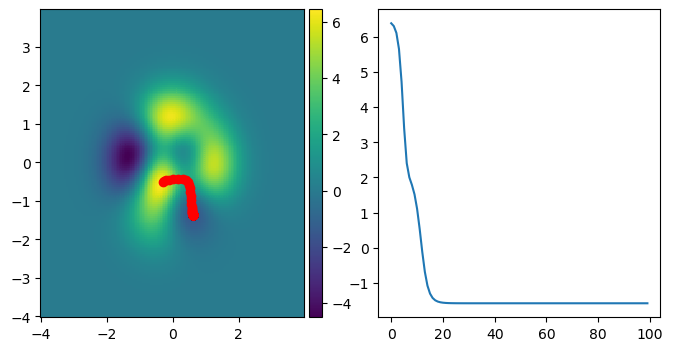

In [58]:
X = torch.arange(-4,4,0.05)
Y = torch.arange(-4,4,0.05)
XX,YY = torch.meshgrid(X,Y,indexing='ij')
ZZ = f_(XX,YY)

n = 100
lr = 0.02
x1 = torch.tensor(-0.3, requires_grad=True)
x2 = torch.tensor(-0.5, requires_grad=True)
COORD = train_model_GD(n, lr, f_, x1, x2)

fig = plt.figure(figsize = (8,4))

ax1 = fig.add_subplot(121)

im1 = ax1.pcolor(XX, YY, ZZ)
im2 = ax1.plot(COORD[0], COORD[1], 'o-r')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im3 = ax2.plot(COORD[2])

In [34]:
x1 = torch.tensor(-0.3, requires_grad=True)
x2 = torch.tensor(-0.5, requires_grad=True)
print(train_model_GD(n,0.14,f_,x1,x2)[2][-1])

-1.54713


In [35]:
def lr_grid(grid):
    res = []
    for elem in grid:
       x1 = torch.tensor(-0.3, requires_grad=True)
       x2 = torch.tensor(-0.5, requires_grad=True)
       res.append(train_model_GD(n,elem,f_,x1,x2)[2][-1])
    return res

In [60]:
grid = np.arange(0.01,0.5,0.005)
tmp = lr_grid(grid)

0.019999999999999997 -1.5846605


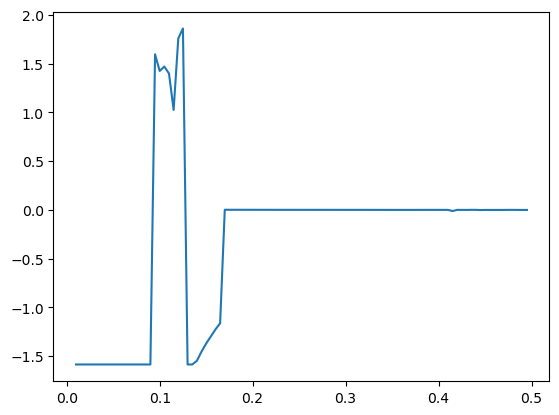

In [61]:
print(grid[np.argmin(tmp)], min(tmp))
plt.plot(grid,tmp)